## Imports

In [2]:
from keras import backend as K
from keras.models import Model
from keras.models import Sequential
from keras.engine.topology import Layer
from keras.layers.merge import Concatenate
from keras.initializers import glorot_uniform
from keras.layers.core import Lambda, Flatten, Dense
from keras.layers.normalization import BatchNormalization
from keras.layers.pooling import MaxPooling2D, AveragePooling2D
from keras.layers import Conv2D, ZeroPadding2D, Activation, Input, concatenate

K.set_image_data_format('channels_first')

import os
import cv2
import numpy as np
import pandas as pd
from PIL import Image
from fr_utils import *
import tensorflow as tf
from imageio import imread
from numpy import genfromtxt
from inception_blocks import *
import matplotlib.pyplot as plt


%matplotlib inline
%load_ext autoreload
%autoreload 2

np.set_printoptions(threshold=np.nan)

# imports for LIME
from skimage.segmentation import mark_boundaries
from lime.wrappers.scikit_image import SegmentationAlgorithm

import sklearn
import sklearn.datasets
import sklearn.ensemble

import lime
import lime.lime_tabular
from lime import lime_image
from __future__ import print_function

C:\Users\tyler.TRN\AppData\Local\Continuum\anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Setup Model

In [3]:
def triplet_loss(y_true, y_pred, alpha = 0.2):

    anchor, positive, negative = y_pred[0], y_pred[1], y_pred[2]

    # distance between the anchor and the positive
    pos_dist = tf.reduce_sum(tf.square(tf.subtract(anchor,positive)),axis=-1)
    
    # distance between the anchor and the negative
    neg_dist = tf.reduce_sum(tf.square(tf.subtract(anchor,negative)),axis=-1)
    
    # subtract the two previous distances and add alpha.
    basic_loss = tf.add(tf.subtract(pos_dist,neg_dist),alpha)
    
    # maximum of basic_loss and 0.0
    loss = tf.reduce_sum(tf.maximum(basic_loss,0))

    return loss

In [4]:
# given image, returns encoding
def img_to_encoding(img1, model):
    img = img1[...,::-1]
    img = np.around(np.transpose(img, (2,0,1))/255.0, decimals=12)
    x_train = np.array([img])
    embedding = model.predict_on_batch(x_train)
    return embedding


# given image path, returns encoding
def img_path_to_encoding(image_path, model):
    return img_to_encoding(cv2.imread(image_path, 1), model)

In [5]:
# specify model input, compile, then load the weights
FRmodel= faceRecoModel(input_shape=(3, 96, 96))
FRmodel.compile(optimizer = 'adam', loss = triplet_loss, metrics = ['accuracy'])
load_weights_from_FaceNet(FRmodel)

## Load Database

In [6]:
# given path to images, fill the database with them
def fillDatabase(databasePath, database):
    databasePath = os.fsencode(databasePath)
    if not os.path.exists(databasePath):
        sys.exit('Invalid database path')
        
    for img in os.listdir(databasePath):
        img_path = os.path.join(databasePath, os.fsencode(img))
        database[img.decode('UTF-8')] = img_path_to_encoding(os.fsdecode(img_path), FRmodel)

In [7]:
database = {}
fillDatabase('images', database)

## Create LIME explainer

In [8]:
# init LIME explainer and segmentation function
explainer = lime_image.LimeImageExplainer(verbose = False)
segmenter = SegmentationAlgorithm('slic', n_segments=50, compactness=1, sigma=1)

In [9]:
# given list of images, gets probability of each image being 'Greg'
def get_probability(imgs):
    dists = []
    for i in range(len(imgs)):
        # runs image through FaceNet model
        encoding = img_to_encoding(imgs[i], FRmodel)
        
        # calculates distance from 'Greg'
        dist = np.linalg.norm(encoding-database["greg_positive.jpg"])
        
        # [prob of being Greg, prob of being not Greg]
        dists.append([1-dist, dist])
    return dists

In [11]:
# outputs superpixel features that most significantly contribute to results
def get_explanation(img_path):
    # get image
    inputIMG = cv2.imread(img_path, 1)
    
    res = get_probability([inputIMG])[0]
    if res[0] > .3:
        print("It is Greg!")
    else:
        print("Imposter! Not Greg.")
    print('prob=', res[0])

    # get explanation from LIME
    explanation = explainer.explain_instance(inputIMG,
                                            classifier_fn = get_probability, top_labels=2, 
                                            hide_color=0, num_samples=400, segmentation_fn=segmenter)
    

    
    # display top 5 features
    for i in range(1, 6):
        temp, mask = explanation.get_image_and_mask(0, positive_only=False, num_features=i, hide_rest=False)
        plt.figure()
        plt.imshow(mark_boundaries(temp, mask))
        
        # show percentage explained by region
        for idx, exp in greg_exp.local_exp[1][0:i]:
            total += exp

        print('Explanation by highlighted region: ', int(-100*total))
    
    return explanation

## Show explanation

Same face: See prediction percentage and top 5 image regions that led to decision.

predict called
return shape= (1, 2)
It is Greg!
prob= 1.0
predict called
return shape= (10, 2)


C:\Users\tyler.TRN\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\ridge.py:152: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number3.193336e-17
  overwrite_a=False)


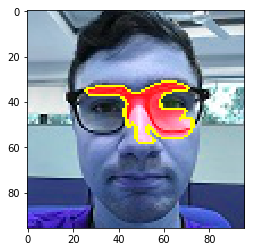

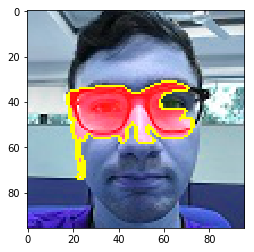

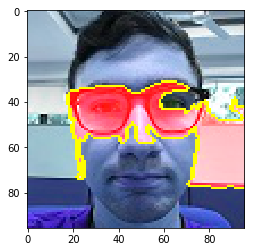

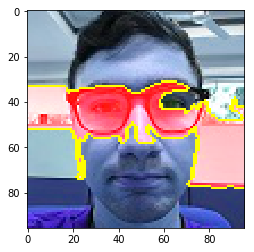

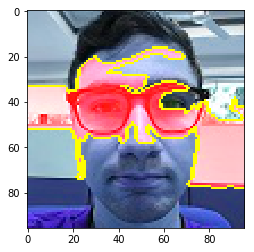

In [27]:
greg_exp = get_explanation("images/greg_positive.jpg")

See full overlay.

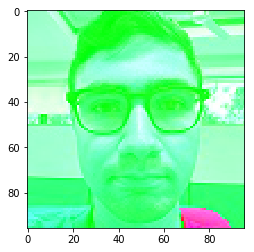

In [122]:
temp, mask = greg_exp.get_image_and_mask(0, positive_only=False, num_features=100, hide_rest=False)
plt.imshow(temp)

Different face: See prediction percentage and top 5 image regions that led to decision.

Imposter! Not Greg.
prob= 0.0658637285232544


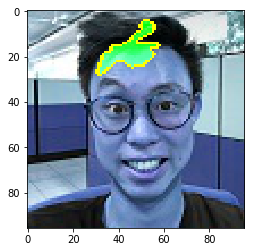

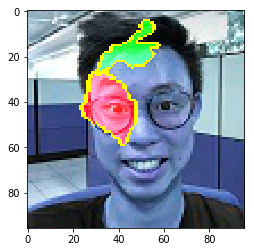

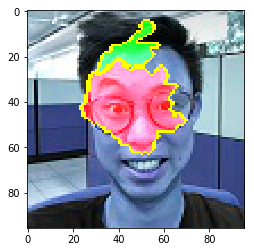

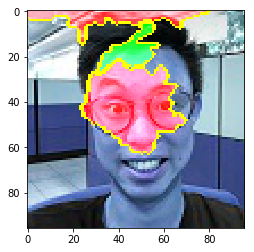

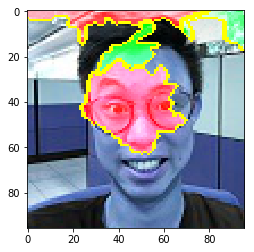

In [58]:
max_exp = get_explanation("images/maxim_positive.jpg")

See full overlay.

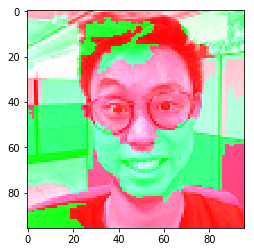

In [59]:
temp, mask = max_exp.get_image_and_mask(0, positive_only=False, num_features=100, hide_rest=False)
plt.imshow(temp)

### Try different tricky images

Stitch top half of one face on bottom half of other.

It is Greg!
prob= 0.33274126052856445


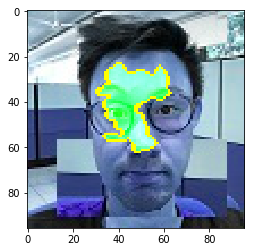

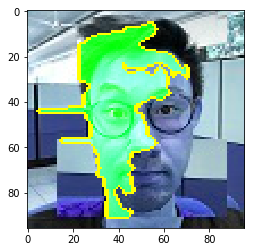

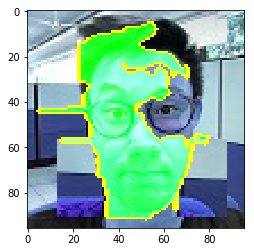

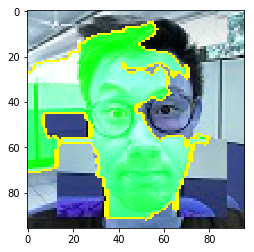

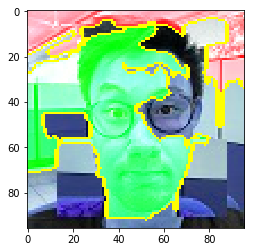

In [48]:
mix_exp = get_explanation('images/stitched_rev.jpg')

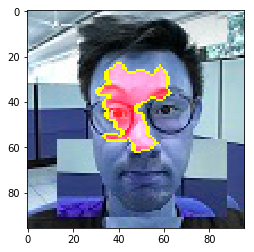

In [54]:
temp, mask = mix_exp.get_image_and_mask(1, positive_only=False, num_features=1, hide_rest=False)
plt.imshow(mark_boundaries(temp, mask))

Try an image where Greg doesn't wear glasses

Imposter! Not Greg.
prob= 0.20578348636627197


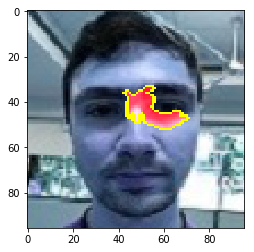

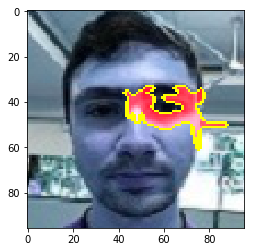

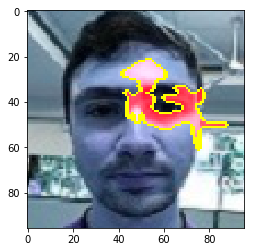

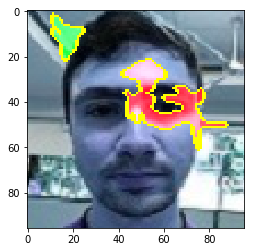

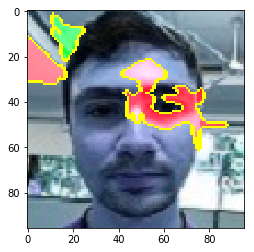

In [67]:
# greg w/o glasses
glassless = get_explanation('images/greg_wo_glasses.jpg')